In [ ]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score,f1_score
import warnings
nltk.download('punkt')
 
# reading the Train Data
inner_list = []
training_data = []
with open("/content/drive/MyDrive/Colab Notebooks/train.txt", "r") as f:
    for line in f:
        res = []
        a = line.split(" ")
        for e in a:
            if e.strip():
                res.append(e)
        if len(res) >= 2:
            if res[0] != "." and res[1] != ".":
                t = (res[0], res[1])
                inner_list.append(t)
            else:
                t = (".", ".")
                inner_list.append(t)
                training_data.append(inner_list)
                inner_list = []
 
 
# reading the Test Data
new_inner_list = []
testing_data = []
with open("/content/drive/MyDrive/Colab Notebooks/test.txt", "r") as f:
    for line in f:
        res = []
        a = line.split(" ")
        for e in a:
            if e.strip():
                res.append(e)
        if len(res) >= 2:
            if res[0] != "." and res[1] != ".":
                t = (res[0], res[1])
                inner_list.append(t)
            else:
                t = (".", ".")
                inner_list.append(t)
                testing_data.append(inner_list)
                inner_list = []
 
 
# Getting list of tagged words
train_tagged_words = [tup for sent in training_data for tup in sent]
len(train_tagged_words)
print("Total number of tagged words : ",len(train_tagged_words))
 
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
 
# vocabulary
V = set(tokens)
print("Total number of vocabs : ",len(V))
 
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print("Number of tags : ",len(T))
print("Tags :")
print(T)
 
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))
 
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)
 
 
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
 
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)
 
 
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
 
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
 
 
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Total number of tagged words :  211727
Total number of vocabs :  19120
Number of tags :  44
Tags :
{'NNPS', 'MD', 'RBS', 'CD', 'JJS', 'VBD', 'NN', '$', 'RBR', 'DT', 'PRP', 'WDT', 'RP', 'PDT', 'JJ', ')', 'NNS', 'VBP', 'WP$', '.', ':', 'VBN', '#', 'POS', 'WRB', 'VBG', 'TO', 'SYM', 'PRP$', 'CC', 'UH', "''", 'FW', '(', 'EX', '``', 'VB', 'NNP', 'VBZ', ',', 'IN', 'JJR', 'RB', 'WP'}


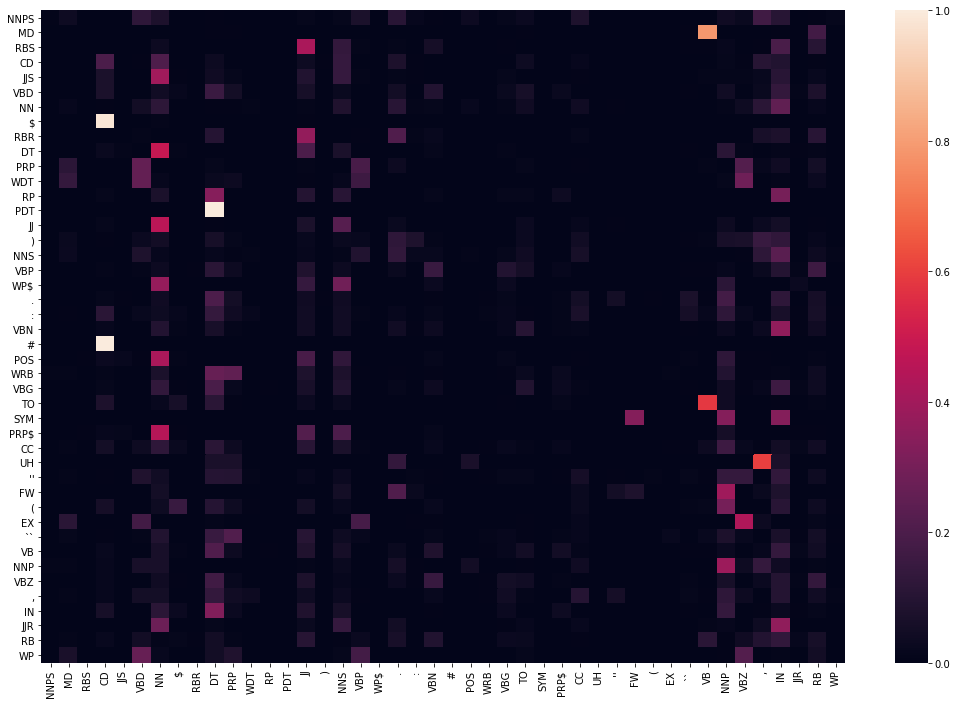

Total number of tagged words in train set :  211727


In [ ]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()
 
print("Total number of tagged words in train set : ",len(train_tagged_words))

In [ ]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))
 
 
print("*********************************************************************************************************************")
total_number_of_sentences_base = 0
total_incorrect_tagged_cases = 0
total_tagged_seq = 0
 
total_accuracy_num = 0
total_precision_num = 0
total_f1score_num = 0
total_recall_num = 0
 
# 1st group of 500 sentences
 
# Running the Viterbi algorithm on 5 sentences at a time
# since running it on the entire data set will take many hours
 
 
for x in range(0,500,5):
    print("Stats for sentences %d to %d :" %(x+1,x+5))
 
 
    # list of tagged words
    number_of_sentences_base = [tup for sent in testing_data[x:x+5] for tup in sent]
    print("-- ",end='')
    print("Number of tagged words given in the test.txt for these 5 sentences  : ",len(number_of_sentences_base))
    total_number_of_sentences_base += len(number_of_sentences_base)
    print("   Total number of tagged words given in the test.txt till now : ",total_number_of_sentences_base)
    print("-- ",end='')
 
    # list of untagged words
    test_tagged_words = [tup[0] for sent in testing_data[x:x+5] for tup in sent]
    the_given_tags = [tup[1] for sent in testing_data[x:x+5] for tup in sent]
 
 
    # tagging the test sentences
    tagged_seq = Viterbi(test_tagged_words)
    print("We tagged words in these 5 sentences : ",len(tagged_seq))
    total_tagged_seq += len(tagged_seq) 
    print("   Total  number of words we tagged till now : ",total_tagged_seq)
    print("-- ",end='')
 
    tagged_by_us = [tup[1] for sent in [tagged_seq] for tup in sent]
    
    # calculating all the scores needed
    warnings.filterwarnings('ignore')
    #Accuracy
    Accuracy = accuracy_score(the_given_tags , tagged_by_us)
    print("Accuracy for these 5 sentences : ", Accuracy)
    total_accuracy_num +=  Accuracy*len(tagged_seq)
    print("   Total Accuracy till now : ", total_accuracy_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Recall
    Recall = recall_score(the_given_tags , tagged_by_us, average="macro")
    print("Recall for these 5 sentences : ", Recall)
    total_recall_num +=  Recall*len(tagged_seq)
    print("   Total Recall till now : ", total_recall_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Precision
    Precision = precision_score(the_given_tags , tagged_by_us, average="macro")
    print("Precision for these 5 sentences : ", Precision)
    total_precision_num +=  Precision*len(tagged_seq)
    print("   Total Precision till now : ", total_precision_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #F1-Score
    F1score = f1_score(the_given_tags , tagged_by_us, average="macro")
    print("F1score for these 5 sentences : ", F1score)
    total_f1score_num +=  F1score*len(tagged_seq)
    print("   Total F1score till now : ", total_f1score_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    incorrect_tagged_cases = [[number_of_sentences_base[i-1],j] for i, j in enumerate(zip(tagged_seq, number_of_sentences_base)) if j[0]!=j[1]]
 
 
    print("Number of incorrectly tagged cases for these 5 sentences: ",len(incorrect_tagged_cases))
    total_incorrect_tagged_cases += len(incorrect_tagged_cases)
    print("   Total number of incorrectly tagged cases : ",total_incorrect_tagged_cases)
    print("")
    
    
    print("*********************************************************************************************************************")

*********************************************************************************************************************
Stats for sentences 1 to 5 :
-- Number of tagged words given in the test.txt for these 5 sentences  :  117
   Total number of tagged words given in the test.txt till now :  117
-- We tagged words in these 5 sentences :  117
   Total  number of words we tagged till now :  117
-- Accuracy for these 5 sentences :  0.8547008547008547
   Total Accuracy till now :  0.8547008547008547
-- Recall for these 5 sentences :  0.828624027487664
   Total Recall till now :  0.8286240274876638
-- Precision for these 5 sentences :  0.9090909090909091
   Total Precision till now :  0.9090909090909091
-- F1score for these 5 sentences :  0.8599261246000377
   Total F1score till now :  0.8599261246000377
-- Number of incorrectly tagged cases for these 5 sentences:  17
   Total number of incorrectly tagged cases :  17

***************************************************************************

In [ ]:
# 2nd group of 500 sentences
 
# Running the Viterbi algorithm on 5 sentences at a time
# since running it on the entire data set will take many hours
 
 
for x in range(500,1000,5):
    print("Stats for sentences %d to %d :" %(x+1,x+5))
 
 
    # list of tagged words
    number_of_sentences_base = [tup for sent in testing_data[x:x+5] for tup in sent]
    print("-- ",end='')
    print("Number of tagged words given in the test.txt for these 5 sentences  : ",len(number_of_sentences_base))
    total_number_of_sentences_base += len(number_of_sentences_base)
    print("   Total number of tagged words given in the test.txt till now : ",total_number_of_sentences_base)
    print("-- ",end='')
 
    # list of untagged words
    test_tagged_words = [tup[0] for sent in testing_data[x:x+5] for tup in sent]
    the_given_tags = [tup[1] for sent in testing_data[x:x+5] for tup in sent]
 
 
    # tagging the test sentences
    tagged_seq = Viterbi(test_tagged_words)
    print("We tagged words in these 5 sentences : ",len(tagged_seq))
    total_tagged_seq += len(tagged_seq) 
    print("   Total  number of words we tagged till now : ",total_tagged_seq)
    print("-- ",end='')
 
    tagged_by_us = [tup[1] for sent in [tagged_seq] for tup in sent]
    
    # calculating all the scores needed
    warnings.filterwarnings('ignore')
    #Accuracy
    Accuracy = accuracy_score(the_given_tags , tagged_by_us)
    print("Accuracy for these 5 sentences : ", Accuracy)
    total_accuracy_num +=  Accuracy*len(tagged_seq)
    print("   Total Accuracy till now : ", total_accuracy_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Recall
    Recall = recall_score(the_given_tags , tagged_by_us, average="macro")
    print("Recall for these 5 sentences : ", Recall)
    total_recall_num +=  Recall*len(tagged_seq)
    print("   Total Recall till now : ", total_recall_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Precision
    Precision = precision_score(the_given_tags , tagged_by_us, average="macro")
    print("Precision for these 5 sentences : ", Precision)
    total_precision_num +=  Precision*len(tagged_seq)
    print("   Total Precision till now : ", total_precision_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #F1-Score
    F1score = f1_score(the_given_tags , tagged_by_us, average="macro")
    print("F1score for these 5 sentences : ", F1score)
    total_f1score_num +=  F1score*len(tagged_seq)
    print("   Total F1score till now : ", total_f1score_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    incorrect_tagged_cases = [[number_of_sentences_base[i-1],j] for i, j in enumerate(zip(tagged_seq, number_of_sentences_base)) if j[0]!=j[1]]
 
 
    print("Number of incorrectly tagged cases for these 5 sentences: ",len(incorrect_tagged_cases))
    total_incorrect_tagged_cases += len(incorrect_tagged_cases)
    print("   Total number of incorrectly tagged cases : ",total_incorrect_tagged_cases)
    print("")
    
    
    print("*********************************************************************************************************************")

In [ ]:
# 3rd group of 500 sentences
 
# Running the Viterbi algorithm on 5 sentences at a time
# since running it on the entire data set will take many hours
 
 
for x in range(1000,1500,5):
    print("Stats for sentences %d to %d :" %(x+1,x+5))
 
 
    # list of tagged words
    number_of_sentences_base = [tup for sent in testing_data[x:x+5] for tup in sent]
    print("-- ",end='')
    print("Number of tagged words given in the test.txt for these 5 sentences  : ",len(number_of_sentences_base))
    total_number_of_sentences_base += len(number_of_sentences_base)
    print("   Total number of tagged words given in the test.txt till now : ",total_number_of_sentences_base)
    print("-- ",end='')
 
    # list of untagged words
    test_tagged_words = [tup[0] for sent in testing_data[x:x+5] for tup in sent]
    the_given_tags = [tup[1] for sent in testing_data[x:x+5] for tup in sent]
 
 
    # tagging the test sentences
    tagged_seq = Viterbi(test_tagged_words)
    print("We tagged words in these 5 sentences : ",len(tagged_seq))
    total_tagged_seq += len(tagged_seq) 
    print("   Total  number of words we tagged till now : ",total_tagged_seq)
    print("-- ",end='')
 
    tagged_by_us = [tup[1] for sent in [tagged_seq] for tup in sent]
    
    # calculating all the scores needed
    warnings.filterwarnings('ignore')
    #Accuracy
    Accuracy = accuracy_score(the_given_tags , tagged_by_us)
    print("Accuracy for these 5 sentences : ", Accuracy)
    total_accuracy_num +=  Accuracy*len(tagged_seq)
    print("   Total Accuracy till now : ", total_accuracy_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Recall
    Recall = recall_score(the_given_tags , tagged_by_us, average="macro")
    print("Recall for these 5 sentences : ", Recall)
    total_recall_num +=  Recall*len(tagged_seq)
    print("   Total Recall till now : ", total_recall_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Precision
    Precision = precision_score(the_given_tags , tagged_by_us, average="macro")
    print("Precision for these 5 sentences : ", Precision)
    total_precision_num +=  Precision*len(tagged_seq)
    print("   Total Precision till now : ", total_precision_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #F1-Score
    F1score = f1_score(the_given_tags , tagged_by_us, average="macro")
    print("F1score for these 5 sentences : ", F1score)
    total_f1score_num +=  F1score*len(tagged_seq)
    print("   Total F1score till now : ", total_f1score_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    incorrect_tagged_cases = [[number_of_sentences_base[i-1],j] for i, j in enumerate(zip(tagged_seq, number_of_sentences_base)) if j[0]!=j[1]]
 
 
    print("Number of incorrectly tagged cases for these 5 sentences: ",len(incorrect_tagged_cases))
    total_incorrect_tagged_cases += len(incorrect_tagged_cases)
    print("   Total number of incorrectly tagged cases : ",total_incorrect_tagged_cases)
    print("")
    
    
    print("*********************************************************************************************************************")

In [ ]:
# 4th group of 500 sentences
 
# Running the Viterbi algorithm on 5 sentences at a time
# since running it on the entire data set will take many hours
 
 
for x in range(1500,len(testing_data),5):
    print("Stats for sentences %d to %d :" %(x+1,x+5))
 
 
    # list of tagged words
    number_of_sentences_base = [tup for sent in testing_data[x:x+5] for tup in sent]
    print("-- ",end='')
    print("Number of tagged words given in the test.txt for these 5 sentences  : ",len(number_of_sentences_base))
    total_number_of_sentences_base += len(number_of_sentences_base)
    print("   Total number of tagged words given in the test.txt till now : ",total_number_of_sentences_base)
    print("-- ",end='')
 
    # list of untagged words
    test_tagged_words = [tup[0] for sent in testing_data[x:x+5] for tup in sent]
    the_given_tags = [tup[1] for sent in testing_data[x:x+5] for tup in sent]
 
 
    # tagging the test sentences
    tagged_seq = Viterbi(test_tagged_words)
    print("We tagged words in these 5 sentences : ",len(tagged_seq))
    total_tagged_seq += len(tagged_seq) 
    print("   Total  number of words we tagged till now : ",total_tagged_seq)
    print("-- ",end='')
 
    tagged_by_us = [tup[1] for sent in [tagged_seq] for tup in sent]
    
    # calculating all the scores needed
    warnings.filterwarnings('ignore')
    #Accuracy
    Accuracy = accuracy_score(the_given_tags , tagged_by_us)
    print("Accuracy for these 5 sentences : ", Accuracy)
    total_accuracy_num +=  Accuracy*len(tagged_seq)
    print("   Total Accuracy till now : ", total_accuracy_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Recall
    Recall = recall_score(the_given_tags , tagged_by_us, average="macro")
    print("Recall for these 5 sentences : ", Recall)
    total_recall_num +=  Recall*len(tagged_seq)
    print("   Total Recall till now : ", total_recall_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #Precision
    Precision = precision_score(the_given_tags , tagged_by_us, average="macro")
    print("Precision for these 5 sentences : ", Precision)
    total_precision_num +=  Precision*len(tagged_seq)
    print("   Total Precision till now : ", total_precision_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    #F1-Score
    F1score = f1_score(the_given_tags , tagged_by_us, average="macro")
    print("F1score for these 5 sentences : ", F1score)
    total_f1score_num +=  F1score*len(tagged_seq)
    print("   Total F1score till now : ", total_f1score_num/total_number_of_sentences_base)
    print("-- ",end='')
 
    incorrect_tagged_cases = [[number_of_sentences_base[i-1],j] for i, j in enumerate(zip(tagged_seq, number_of_sentences_base)) if j[0]!=j[1]]
 
 
    print("Number of incorrectly tagged cases for these 5 sentences: ",len(incorrect_tagged_cases))
    total_incorrect_tagged_cases += len(incorrect_tagged_cases)
    print("   Total number of incorrectly tagged cases : ",total_incorrect_tagged_cases)
    print("")
    
    
    print("*********************************************************************************************************************")